# **Run the airGR (GR6J) lumped catchment hydrological model**

#UKCEH West Africa Hydrological Forecasting Training Workshop 2026

Katie Facer-Childs, Ezra Kitson, Eugene Magee, Adriana Calderon, Lucy Barker

(c) UKCEH 2026

This R code is an example of running the airGR model. It uses freely available data for the River Coln at Bilbury (ID: 39020).

In [ ]:
#install packages
install.packages(c("airGR", "plotly",
                    "htmlwidgets"))

#load packages
library(plotly)
library(htmlwidgets)
library(airGR)
library(RColorBrewer)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘crosstalk’


Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




**Load some observed flow data**

In [ ]:
#Load data from Github
observed_data <- read.csv(
  'https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/Qobs_39020.csv')
#correct date format
observed_data$DATE <- strptime(observed_data$DATE, format = "%d/%m/%Y")

In [ ]:
class(observed_data)
ncol(observed_data)

[1] "data.frame"

[1] 2

**Make a quick plot to look at the observed data**

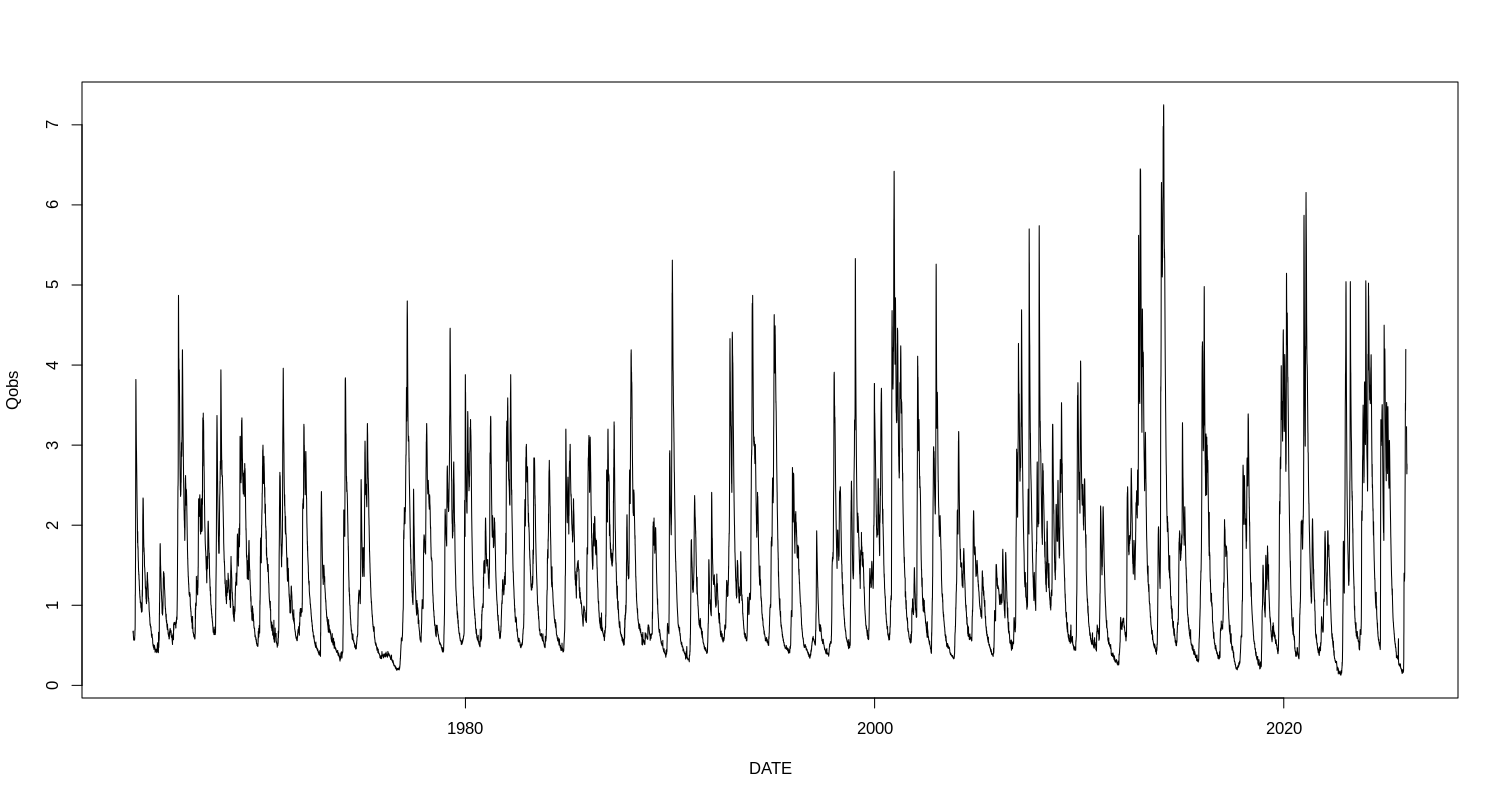

In [ ]:
#first set the dimensions of the plots in this notebook
options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 100)
#then plot
plot(observed_data,type="l")


**Zoom in to a smaller time-frame**

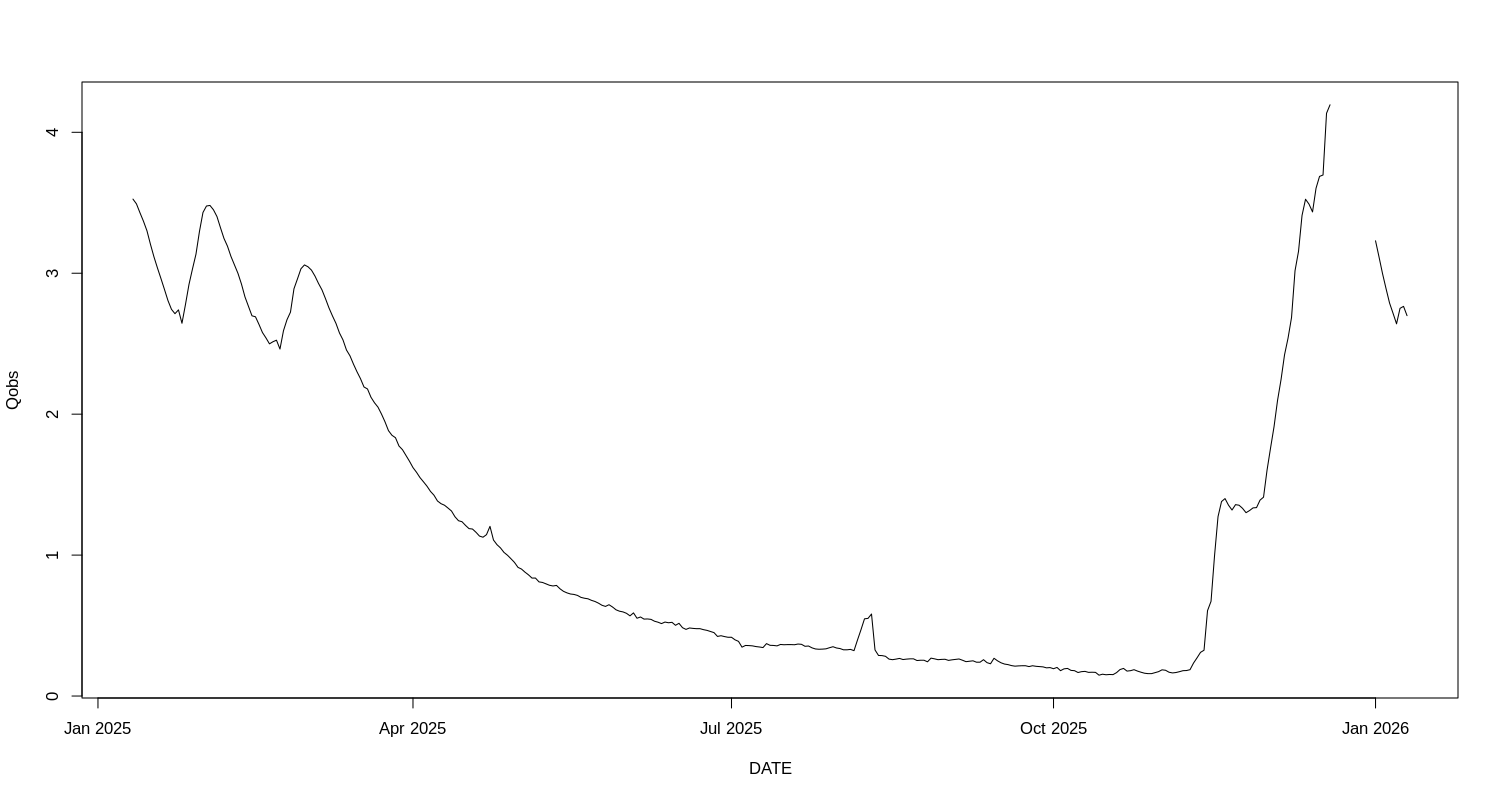

In [ ]:
plot(tail(observed_data,n=365),type="l")

**Load in observed precipitation and Potential Evapotranspiration (PET) data for the catchment (or basin)**

In [ ]:
precip_data<-read.csv("https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/rain_39020.csv")
PET_data<-read.csv("https://raw.githubusercontent.com/NERC-CEH/ghana_hydro_training_2026/main/Day3_Seasonal_Forecast_Application/InputFiles/PET_39020.csv")
#convert date format again
precip_data$DATE <- strptime(precip_data$DATE, "%Y-%m-%d")
PET_data$DATE <- strptime(PET_data$DATE, "%Y-%m-%d")

**Find a common time period between the precipitation and PET datasets**

In [ ]:
first_date <- max(observed_data$DATE[1], precip_data$DATE[1], PET_data$DATE[1])
last_date <- min(observed_data$DATE[length(observed_data$DATE)], precip_data$DATE[length(precip_data$DATE)], PET_data$DATE[length(PET_data$DATE)])

In [ ]:
first_date <- max(observed_data$DATE[1],
                  precip_data$DATE[1],
                  PET_data$DATE[1])

last_date  <- min(observed_data$DATE[length(observed_data$DATE)],
                  precip_data$DATE[length(precip_data$DATE)],
                  PET_data$DATE[length(PET_data$DATE)])

print(first_date)
print(last_date)

[1] "1963-10-01 UTC"
[1] "2023-12-31 UTC"


**Create a data frame of the right length for the observed flow, precipitation and PET data**

In [ ]:
#make an empty data frame
thames_data <- as.data.frame(matrix(NA,nrow=as.numeric((last_date-first_date)+1), ncol=4))
colnames(thames_data) <-c ("date","PET","precip","obs")
#make the date timeseries
thames_data$date <- seq(first_date, last_date, by="days")
#populate the data frame with the data
thames_data$obs <- observed_data$Qobs[which(observed_data$DATE==thames_data$date[1]):which(observed_data$DATE==thames_data$date[length(thames_data$date)])]
thames_data$precip <- precip_data$Mean_rainfall[which(precip_data$DATE==thames_data$date[1]):which(precip_data$DATE==thames_data$date[length(thames_data$date)])]
thames_data$PET <- PET_data$PET[which(PET_data$DATE==thames_data$date[1]):which(PET_data$DATE==thames_data$date[length(thames_data$date)])]
#convert the observed discharge to runoff (so its in the same units as the precip)
# divide by catchment area (m2) and mulitply by 86.4
thames_data$obs <- (thames_data$obs/106.7)*86.4

In [ ]:
tail(thames_data)

,date,PET,precip,obs
,<dttm>,<dbl>,<dbl>,<dbl>
22002,2023-12-26,0.3330972,7.283461,2.458392
22003,2023-12-27,0.3327346,12.863885,2.490782
22004,2023-12-28,0.3618337,4.884535,2.461631
22005,2023-12-29,0.3349874,4.391342,2.434909
22006,2023-12-30,0.3328977,20.103901,2.508596
22007,2023-12-31,0.3186501,6.545548,2.679453


# So, now let's do some modelling
Check this website for a good guide through the model:
https://hydrogr.github.io/airGR/

**Prepare the input data in the correct format**

In [ ]:
BasinObs <- thames_data
colnames(BasinObs) <- c('DatesR','E','P', 'Qobs')
head(BasinObs)

,DatesR,E,P,Qobs
,<dttm>,<dbl>,<dbl>,<dbl>
1,1963-10-01,1.1251870,6.3996244,0.5409110
2,1963-10-02,1.0201779,1.2624184,0.5409110
3,1963-10-03,1.0773419,4.2700833,0.5481987
4,1963-10-04,1.0389210,0.1563817,0.5271453
5,1963-10-05,0.9952503,5.6927670,0.5409110
6,1963-10-06,0.9901612,1.2817926,0.5481987


**Build Model Inputs for GR6J**

In [ ]:
# this defines which model we want to run, and defines the variables for the models input data
# note NA values of precip and PET are NOT ALLOWED
InputsModel <- CreateInputsModel(FUN_MOD = RunModel_GR6J,DatesR = BasinObs$DatesR,
                                 Precip = BasinObs$P,PotEvap = BasinObs$E)
str(InputsModel)

List of 3
 $ DatesR : POSIXlt[1:22007], format: "1963-10-01" "1963-10-02" ...
 $ Precip : num [1:22007] 6.4 1.262 4.27 0.156 5.693 ...
 $ PotEvap: num [1:22007] 1.125 1.02 1.077 1.039 0.995 ...
 - attr(*, "FeatFUN_MOD")=List of 11
  ..$ CodeMod     : chr "GR6J"
  ..$ NameMod     : chr "GR6J"
  ..$ NbParam     : int 6
  ..$ TimeUnit    : chr "daily"
  ..$ Id          : logi NA
  ..$ Class       : chr [1:2] "daily" "GR"
  ..$ Pkg         : chr "airGR"
  ..$ NameFunMod  : chr "RunModel_GR6J"
  ..$ TimeStep    : num 86400
  ..$ TimeStepMean: int 86400
  ..$ CodeModHydro: chr "GR6J"
 - attr(*, "class")= chr [1:3] "InputsModel" "daily" "GR"


**Define Run options**

Experiment by changing the simulation period and comparing how the results differ.

In [ ]:
#define simulation period
Ind_Run <- seq(which(BasinObs$DatesR=="1981-01-01"),
               which(BasinObs$DatesR=="2023-12-31"))
RunOptions <- suppressWarnings(
  CreateRunOptions(
    FUN_MOD = RunModel_GR6J,
    InputsModel = InputsModel,
    IndPeriod_Run = Ind_Run,
    IndPeriod_WarmUp = NULL
  )
)
#print what the RunOptions look like
str(RunOptions)

List of 8
 $ IndPeriod_WarmUp: int [1:366] 5937 5938 5939 5940 5941 5942 5943 5944 5945 5946 ...
 $ IndPeriod_Run   : int [1:15705] 6303 6304 6305 6306 6307 6308 6309 6310 6311 6312 ...
 $ IniStates       : Named num [1:71] 350 90 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "names")= chr [1:71] "Store.Prod" "Store.Rout" "Store.Exp" "Store.Int" ...
 $ IniResLevels    : num [1:4] 0.3 0.5 0 NA
 $ Outputs_Cal     : chr [1:2] "Qsim" "Param"
 $ Outputs_Sim     : Named chr [1:24] "DatesR" "PotEvap" "Precip" "Prod" ...
  ..- attr(*, "names")= chr [1:24] "" "GR1" "GR2" "GR3" ...
 $ FortranOutputs  :List of 2
  ..$ GR: chr [1:20] "PotEvap" "Precip" "Prod" "Pn" ...
  ..$ CN: NULL
 $ FeatFUN_MOD     :List of 12
  ..$ CodeMod     : chr "GR6J"
  ..$ NameMod     : chr "GR6J"
  ..$ NbParam     : int 6
  ..$ TimeUnit    : chr "daily"
  ..$ Id          : logi NA
  ..$ Class       : chr [1:2] "daily" "GR"
  ..$ Pkg         : chr "airGR"
  ..$ NameFunMod  : chr "RunModel_GR6J"
  ..$ TimeStep    : num 86400
  ..$ Ti

**Create the InputsCrit object - define the model performance (or 'error') metric -- you can choose from RMSE, NSE, KGE or modified KGE (KGE2)**

In [ ]:
InputsCrit <- CreateInputsCrit(FUN_CRIT = ErrorCrit_NSE,
                               InputsModel = InputsModel,
                               RunOptions = RunOptions,
                               Obs = BasinObs$Qobs[Ind_Run])
str(InputsCrit)


List of 8
 $ FUN_CRIT:function (InputsCrit, OutputsModel, warnings = TRUE, verbose = TRUE)  
  ..- attr(*, "class")= chr [1:2] "FUN_CRIT" "function"
 $ Obs     : num [1:15705] 1.51 1.51 1.47 1.44 1.42 ...
 $ VarObs  : chr "Q"
 $ BoolCrit: logi [1:15705] TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ idLayer : logi NA
 $ transfo : chr ""
 $ epsilon : NULL
 $ Weights : NULL
 - attr(*, "class")= chr [1:2] "Single" "InputsCrit"


**Set the calibration option to the default GR6J calibration algorithm**


In [ ]:
CalibOptions <- CreateCalibOptions(FUN_MOD = RunModel_GR6J,
                                   FUN_CALIB = Calibration_Michel)
str(CalibOptions)

List of 4
 $ FixedParam       : logi [1:6] NA NA NA NA NA NA
 $ SearchRanges     : num [1:2, 1:6] 4.59e-05 2.18e+04 -1.09e+04 1.09e+04 4.59e-05 ...
 $ FUN_TRANSFO      :function (ParamIn, Direction)  
 $ StartParamDistrib: num [1:3, 1:6] 36.598 49.402 90.017 -1.175 -0.521 ...
 - attr(*, "class")= chr [1:4] "CalibOptions" "daily" "GR" "HBAN"


**Run the calibration**

In [ ]:
OutputsCalib <- Calibration_Michel(InputsModel = InputsModel,
                                   RunOptions = RunOptions,
                                   InputsCrit = InputsCrit,
                                   CalibOptions = CalibOptions,
                                   FUN_MOD = RunModel_GR6J,
                                   FUN_CRIT = ErrorCrit_NSE)

Warning message in Calibration_Michel(InputsModel = InputsModel, RunOptions = RunOptions, :
“argument 'FUN_CRIT' is deprecated. The error criterion function is now automatically get from the 'InputsCrit' object”
Grid-Screening in progress (
0%
 20%
 40%
 60%
 80%
 100%)

	 Screening completed (729 runs)

	     Param =   90.017,   -0.521,  148.413,    2.345,    0.220,   54.598

	     Crit. NSE[Q]       = 0.6516

Steepest-descent local search in progress

	 Calibration completed (79 iterations, 1669 runs)

	     Param =  219.350,   -0.177,  715.160,    6.401,    0.098,   13.302

	     Crit. NSE[Q]       = 0.9418



NSE = 0.9418 - not bad!!

**Define the parameters found by the calibration routine**

In [ ]:
Param <- OutputsCalib$ParamFinalR
Param

[1] 219.34982527  -0.17690803 715.15989145   6.40103167   0.09814285
[6]  13.30157921

## RUN THE MODEL

In [ ]:
OutputsModel <- RunModel_GR6J(InputsModel = InputsModel,
                              RunOptions = RunOptions,
                              Param= Param)
str(OutputsModel)

List of 23
 $ DatesR    : POSIXlt[1:15705], format: "1981-01-01" "1981-01-02" ...
 $ PotEvap   : num [1:15705] 0.318 0.345 0.353 0.278 0.261 ...
 $ Precip    : num [1:15705] 0.1903 0.1491 0.0482 0.0399 0.0355 ...
 $ Prod      : num [1:15705] 169 168 167 166 166 ...
 $ Pn        : num [1:15705] 0 0 0 0 0 ...
 $ Ps        : num [1:15705] 0 0 0 0 0 ...
 $ AE        : num [1:15705] 0.311 0.334 0.336 0.265 0.248 ...
 $ Perc      : num [1:15705] 0.584 0.571 0.556 0.544 0.531 ...
 $ PR        : num [1:15705] 0.584 0.571 0.556 0.544 0.531 ...
 $ Q9        : num [1:15705] 0.658 0.574 0.552 0.539 0.526 ...
 $ Q1        : num [1:15705] 0.0853 0.0789 0.0733 0.0682 0.0639 ...
 $ Rout      : num [1:15705] 238 238 237 237 237 ...
 $ Exch      : num [1:15705] -0.0417 -0.0416 -0.0415 -0.0414 -0.0412 ...
 $ AExch1    : num [1:15705] -0.0417 -0.0416 -0.0415 -0.0414 -0.0412 ...
 $ AExch2    : num [1:15705] -0.0417 -0.0416 -0.0415 -0.0414 -0.0412 ...
 $ AExch     : num [1:15705] -0.125 -0.125 -0.124 -0.124

**Use the model's inbuilt plot function to look at the results**

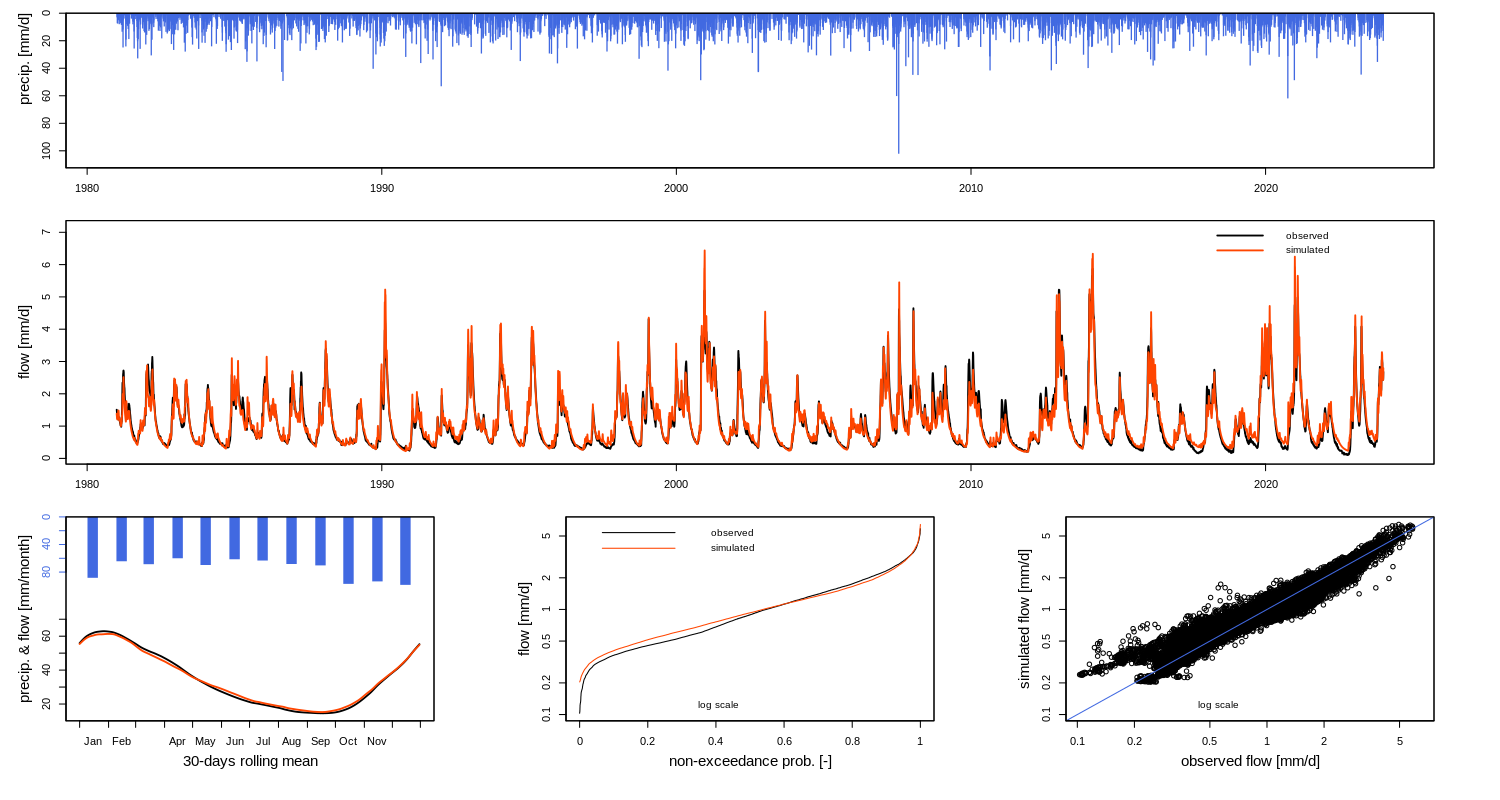

In [ ]:
plot(OutputsModel, Qobs=BasinObs$Qobs[Ind_Run])

Looking good - but we've got some discrepancy at the low flows end.

*Look at the non-exceedance probabilty plot, in the middle of the bottom row.*

NSE is well known for this, it is based on the square of the flows, so over-weights the calibration to the high flows.

I wonder if the modified KGE can do any better?

**Tweak the calibration criteria**

Grid-Screening in progress (
0%
 20%
 40%
 60%
 80%
 100%)

	 Screening completed (729 runs)

	     Param =   90.017,   -0.521,  148.413,    2.345,    0.220,   54.598

	     Crit. KGE2[Q]      = 0.7969

Steepest-descent local search in progress

	 Calibration completed (62 iterations, 1464 runs)

	     Param =  218.538,   -0.387,  505.255,    6.379,    0.230,   14.953

	     Crit. KGE2[Q]      = 0.9681



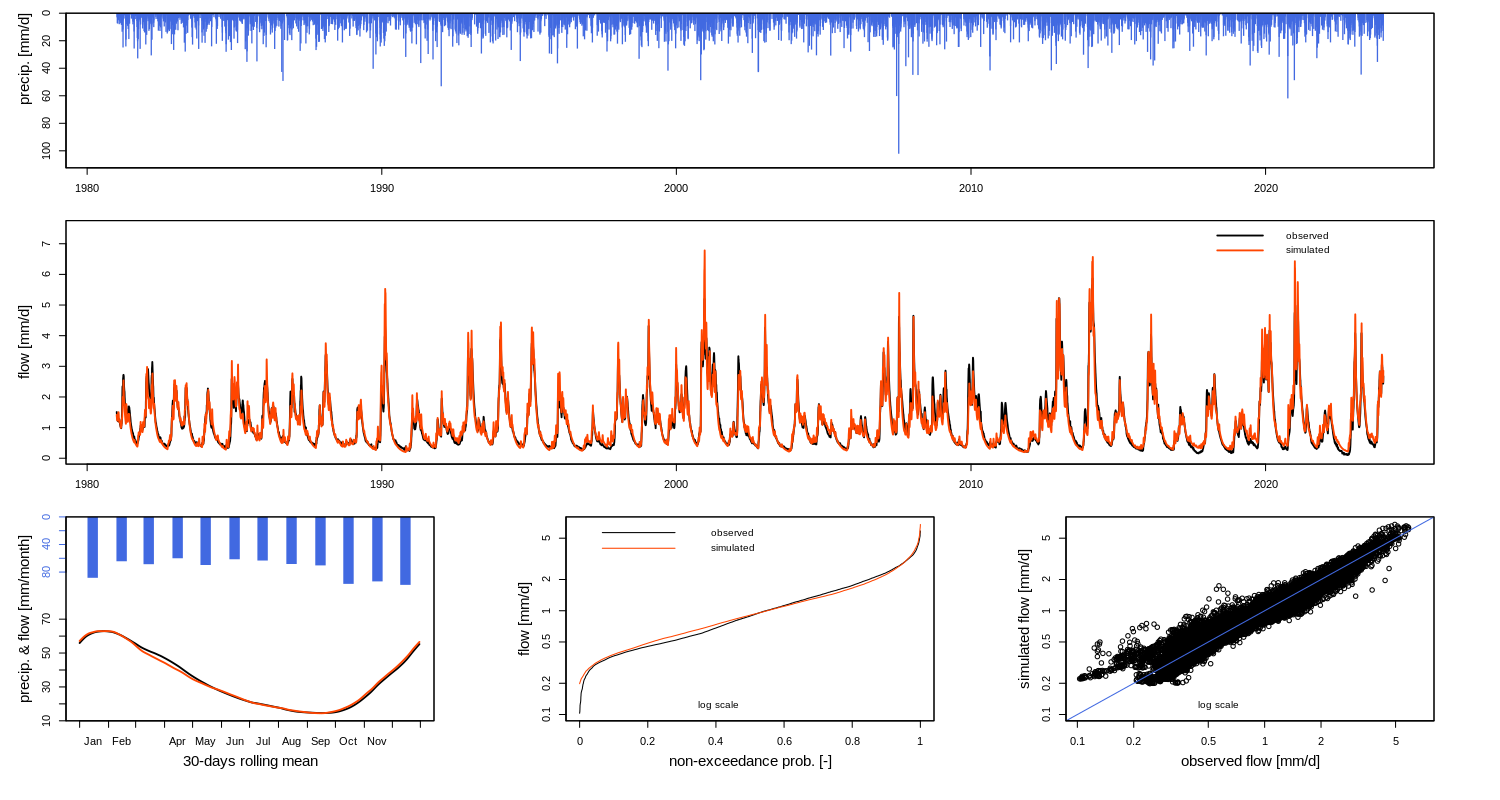

In [ ]:
# make a few changes to the calibration criteria
InputsCrit <- CreateInputsCrit(FUN_CRIT = ErrorCrit_KGE2,
                               InputsModel = InputsModel,
                               RunOptions = RunOptions,
                               Obs = BasinObs$Qobs[Ind_Run])
# rerun the calibration
OutputsCalib <- Calibration_Michel(InputsModel = InputsModel,
                                   RunOptions = RunOptions,
                                   InputsCrit = InputsCrit,
                                   CalibOptions = CalibOptions,
                                   FUN_MOD = RunModel_GR6J)#,
                                   #FUN_CRIT = ErrorCrit_KGE2)

# redefine the parameters
Param <- OutputsCalib$ParamFinalR
# rerun the model
OutputsModel <- RunModel_GR6J(InputsModel = InputsModel,
                              RunOptions = RunOptions,
                              Param= Param)
# plot again
plot(OutputsModel, Qobs=BasinObs$Qobs[Ind_Run])

# not much different. Oh well, we can be happy with either of those metric scores.
# - pause for thought - which parameter set would you choose to use?!

I think that looks slightly better...!

## Let's do some validation

 Go back to the beginning, redefine the period to run on

In [ ]:
#(the period we haven't used for calibration, minus the first year needed for warm up)
Ind_Run <- seq(which(BasinObs$DatesR=="1963-10-01"),
               which(BasinObs$DatesR=="1980-12-31"))
RunOptions <- CreateRunOptions(FUN_MOD = RunModel_GR6J,
                               InputsModel = InputsModel,
                               IndPeriod_Run = Ind_Run,
                               IndPeriod_WarmUp = NULL)

InputsCrit <- CreateInputsCrit(FUN_CRIT = ErrorCrit_KGE2,
                               InputsModel = InputsModel,
                               RunOptions = RunOptions,
                               Obs = BasinObs$Qobs[Ind_Run])
Param <- OutputsCalib$ParamFinalR
OutputsModel <- RunModel_GR6J(InputsModel = InputsModel,
                              RunOptions = RunOptions,
                              Param= Param)
OutputsCrit <- ErrorCrit_KGE2(InputsCrit = InputsCrit,
                              OutputsModel = OutputsModel)

model warm up period not defined: default configuration used
 no data were found for model warm up! No warm up period is used

Warning message in CreateRunOptions(FUN_MOD = RunModel_GR6J, InputsModel = InputsModel, :
“model warm up period not defined: default configuration used
 no data were found for model warm up!”
Warning message in CreateIniStates(FUN_MOD = FUN_MOD, InputsModel = InputsModel, :
“'RunModel_GR6J' does not require 'IntStore'. Values set to NA”
Warning message in CreateIniStates(FUN_MOD = FUN_MOD, InputsModel = InputsModel, :
“'RunModel_GR6J' does not require 'GCemaNeigeLayers' 'GCemaNeigeLayers', 'GthrCemaNeigeLayers' and 'GlocmaxCemaNeigeLayers'. Values set to NA”
Crit. KGE2[Q] = 0.8661

	SubCrit. KGE2[Q] cor(sim, obs, "pearson") = 0.8798 
	SubCrit. KGE2[Q] cv(sim)/cv(obs)          = 1.0387 
	SubCrit. KGE2[Q] mean(sim)/mean(obs)      = 1.0445 




Slightly worse than the calibration period (KGE=0.8661) but not bad at all.

**Finally, lets run the model for the whole time period**


In [ ]:

Ind_Run <- seq(which(BasinObs$DatesR=="1964-01-01"),
               which(BasinObs$DatesR=="2023-12-31"))
RunOptions <- CreateRunOptions(FUN_MOD = RunModel_GR6J,
                               InputsModel = InputsModel,
                               IndPeriod_Run = Ind_Run,
                               IndPeriod_WarmUp = NULL)

Param <- OutputsCalib$ParamFinalR
OutputsModel <- RunModel_GR6J(InputsModel = InputsModel,
                              RunOptions = RunOptions,
                              Param= Param)

Warning message in CreateRunOptions(FUN_MOD = RunModel_GR6J, InputsModel = InputsModel, :
“model warm up period not defined: default configuration used
  less than a year (without missing values) was found for model warm up:
  (92 time-steps are used for initialisation)”
Warning message in CreateIniStates(FUN_MOD = FUN_MOD, InputsModel = InputsModel, :
“'RunModel_GR6J' does not require 'IntStore'. Values set to NA”
Warning message in CreateIniStates(FUN_MOD = FUN_MOD, InputsModel = InputsModel, :
“'RunModel_GR6J' does not require 'GCemaNeigeLayers' 'GCemaNeigeLayers', 'GthrCemaNeigeLayers' and 'GlocmaxCemaNeigeLayers'. Values set to NA”


We can explore things a bit more with the airGR teaching package: open this browser page and explore what happens when you change parameter values etc. https://sunshine.inrae.fr/app/airGRteaching

**Build an interactive plot of observed vs simulated flow using plotly**

 Save the interactive figure as an HTML file. You’ll find it in the Files panel (left sidebar). Download it and open it in a web browser to zoom, pan, and hover for values.

In [ ]:
#convert model output dates for plotting in plotly
x_dates <- as.POSIXct(OutputsModel$DatesR)

#create interactive plot
p <- plot_ly() %>%
  add_lines(x = x_dates, y = BasinObs$Qobs[Ind_Run], name = 'Observed') %>%
  add_lines(x = x_dates, y = OutputsModel$Qsim,        name = 'Simulated') %>%
  layout(title = 'Observed vs Simulated Flow',
         xaxis = list(title = ''),
         yaxis = list(title = 'Flow (mm/day)'))

#save plot as an html file (download from Files left pane)
htmlwidgets::saveWidget(p, 'plotly_flow.html', selfcontained = TRUE)


# Next we'll use the GR6J model to run an ESP forecast with the "2. Run ESP" Notebook